In [2]:
# libs --------------------------------------------------------------------
require(SummarizedExperiment)
require(data.table)
require(tidyverse)
require(ggplot2)
require(scales)
require(ggpubr)
require(ComplexHeatmap)
require(pheatmap)
require(RColorBrewer)
require(parallelDist)
require(matlab)
require(cluster)
require(rlist)
require(chromVAR)
require(ggdendro)
require(extrafont)  # fonts 
# https://blog.revolutionanalytics.com/2012/09/how-to-use-your-favorite-fonts-in-r-charts.html
suppressMessages(loadfonts())
require(ggthemes)
# #https://rpubs.com/Koundy/71792 theme_Publication
require(ComplexHeatmap)
cols.hm.avg.tf <- colorRampPalette(c(rgb(249, 249, 212, maxColorValue = 255), rgb(60, 
    181, 195, maxColorValue = 255), rgb(30, 35, 86, maxColorValue = 255)), space = "Lab")



theme_pubr<- function (base_size = 11, base_family = "Arial") 
{
    theme_foundation() + theme(line = element_line(colour = "black", 
        lineend = "round", linetype = "solid"), rect = element_rect(fill = "white", 
        colour = "black", linetype = "solid"), text = element_text(colour = "black", 
        face = "plain", family = base_family, size = base_size, 
        vjust = 0.5, hjust = 0.5, lineheight = 0.5), panel.background = element_blank(), 
        plot.background = element_blank(), panel.border = element_rect(colour = "black", 
            fill = NA), panel.grid = element_blank(), strip.background = element_rect(colour = NA), 
        legend.key = element_rect(colour = NA), title = element_text(size = rel(1)), 
        plot.title = element_text(size = rel(1.2), face = "bold"), 
        strip.text = element_text(), axis.ticks.length = unit(1, 
    "mm"))
}


# colors ------------------------------------------------------------------
cols.subcluster <- c('red4','red3','red1','steelblue4','steelblue1','green4','green1',
                     'purple4','purple1',brewer.pal(9,'Set1')[5:9])
cols.celltype <- c(acinar='grey',alpha_1="darkred",alpha_2="lightpink",beta_1="darkgreen",beta_2="lightgreen",
                   delta_1="orange",delta_2="gold",ductal="cyan",
                   gamma="purple",exocrine="black",endothelial_1="royalblue",endothelial_2="navy",immune="blue",
                   stellate="skyblue",glial="cyan")
cols.celltype["beta"] = rgb(t((col2rgb(cols.celltype["beta_1"]) + col2rgb(cols.celltype["beta_2"]))/2), 
    maxColorValue = 255)
cols.celltype["alpha"] = rgb(t((col2rgb(cols.celltype["alpha_1"]) + col2rgb(cols.celltype["alpha_2"]))/2), 
    maxColorValue = 255)
cols.celltype["delta"] = rgb(t((col2rgb(cols.celltype["delta_1"]) + col2rgb(cols.celltype["delta_2"]))/2), 
    maxColorValue = 255)
cols.celltype["endothelial"] = rgb(t((col2rgb(cols.celltype["endothelial_1"]) + col2rgb(cols.celltype["endothelial_2"]))/2), 
    maxColorValue = 255)



##  1. load data

In [3]:
dat.pro_ps<- fread("../dat/1910_v2/abd.promoter.long_matrix_w_transcripts_ps.txt")
head(dat.pro_ps,1)
dim(dat.pro_ps)

prom_peak,cell,ps,celltype
<chr>,<chr>,<dbl>,<chr>
10:100027284-100028604,Islet1fresh_AGACACCTAAGAGGCAGCGTAAGAAGGCG,11.8747,alpha


[1] 18019112        4

## 2. function to get openning  along ps bins for pomoter

In [9]:
## load all required data 
ps.range <- lapply(c("alpha", "beta", "delta"), function(ct) dat.pro_ps %>% filter(celltype == 
    ct) %>% pull(ps) %>% range)
names(ps.range) <- c("alpha", "beta", "delta")
ps.range %>% t
N.bin <- 101
N.bin.d <- 21
ps.bks <- list()
ps.bks$alpha <- seq(ps.range$alpha[1], ps.range$alpha[2] + 1e-05, length.out = N.bin)
ps.bks$beta <- seq(ps.range$beta[1], ps.range$beta[2] + 1e-05, length.out = N.bin)
ps.bks$delta <- seq(ps.range$delta[1], ps.range$delta[2] + 1e-05, length.out = N.bin.d)

dat.ps.bins <- fread("../dat/1910_v2/ps.bin.dat.sum.csv") %>% select(ps_bin_idx, 
    ps_bin, celltype, N)

alpha,beta,delta
<dbl>,<dbl>,<dbl>
"0.00000, 20.85655","0.00000, 18.49255","0.00000, 14.97356"


Joining, by = c("ps_bin", "celltype")


[1] -0.9785583  7.5990774

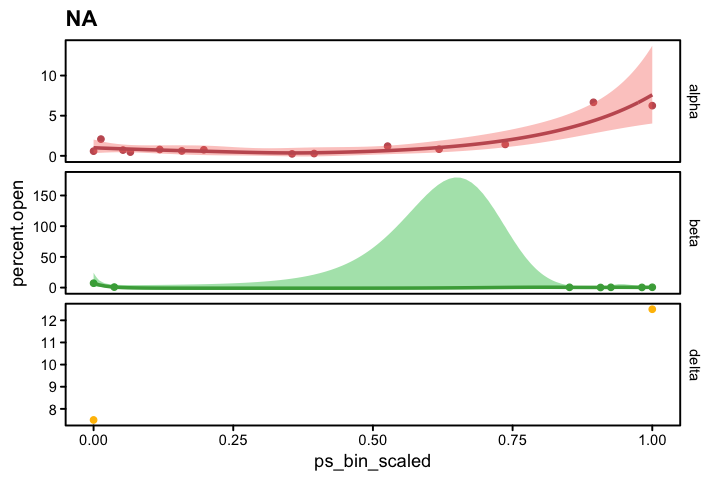

In [14]:
## functions
fun.getOpenCellsPerBin <- function(prom = "10:100027284-100028604") {
    
    dat.pro_ps.sub <- dat.pro_ps %>% filter(prom_peak == prom)
    
    ## put each cell in bins
    dat.pro_ps.sub <- rbind(dat.pro_ps.sub %>% filter(celltype == "alpha") %>% mutate(ps_bin = cut(ps, 
        breaks = ps.bks$alpha, include.lowest = T, right = F)), dat.pro_ps.sub %>% 
        filter(celltype == "beta") %>% mutate(ps_bin = cut(ps, breaks = ps.bks$beta, 
        include.lowest = T, right = F)), dat.pro_ps.sub %>% filter(celltype == "delta") %>% 
        mutate(ps_bin = cut(ps, breaks = ps.bks$delta, include.lowest = T, right = F)))
    ## count
    setDT(dat.pro_ps.sub)
    dat.pro_ps.sub.cnt <- dat.pro_ps.sub[, .(open_cells = .N), by = .(ps_bin, celltype)] %>% 
        left_join(dat.ps.bins) %>% select(ps_bin_idx, ps_bin, open_cells, N, celltype)
    dat.pro_ps.sub.cnt
}
fun.addSmoothFracPerBin <- function(promoter = "10:100027284-100028604", doPlot = F, 
    npoints = 100, title = NA, sm_method = "loess", ...) {
    scale_range <- function(x) (x - min(x))/(max(x) - min(x))
    tmp <- fun.getOpenCellsPerBin(promoter) %>% mutate(percent.open = open_cells/N * 
        100)
    setDT(tmp)
    tmp[, `:=`(ps_bin_scaled, scale_range(ps_bin_idx)), by = celltype]
    
    ## avoid negative
    ## https://stackoverflow.com/questions/2777053/in-ggplot-restrict-y-to-be-0-in-loess
    require(scales)
    # create exp(x)-1 transformation, the inverse of log(1+p)
    expm1_trans <- function() trans_new("expm1", "expm1", "log1p")
    
    
    p <- ggplot(tmp, aes(ps_bin_scaled, percent.open, color = celltype, fill = celltype)) + 
        geom_point() + scale_color_manual(values = cols.celltype) + stat_smooth(aes(color = celltype, 
        outfit = fit.y <<- ..y..), n = npoints, method = sm_method, ...) + theme_pubr() + 
        facet_grid(celltype ~ ., scales = "free_y") + theme(legend.position = "none", 
        strip.background = element_blank()) + ggtitle(title) + scale_y_continuous(trans = log1p_trans()) + 
        coord_trans(y = expm1_trans(), clip = "off")  #+ coord_cartesian(expand = F, clip = 'off')
    
    if (doPlot) 
        print(p)
    valid.dat <- p$data %>% group_by(celltype) %>% summarise(ps.number = n()) %>% 
        filter(ps.number > 2)
    return(list(plt = p, smoothed.data = data.frame(ps = rep(seq(0, 1, length.out = npoints), 
        nrow(valid.dat)), smoothed.percent.open = expm1(fit.y), celltype = rep(valid.dat$celltype, 
        each = npoints))))
}



options(repr.plot.width = 6, repr.plot.height = 4)
suppressWarnings(res <- fun.addSmoothFracPerBin(doPlot = T, promoter = "10:71332283-71332739"))
res$smoothed.data$smoothed.percent.open %>% range

Joining, by = c("ps_bin", "celltype")


   user  system elapsed 
  0.493   0.065   0.566 

Joining, by = c("ps_bin", "celltype")


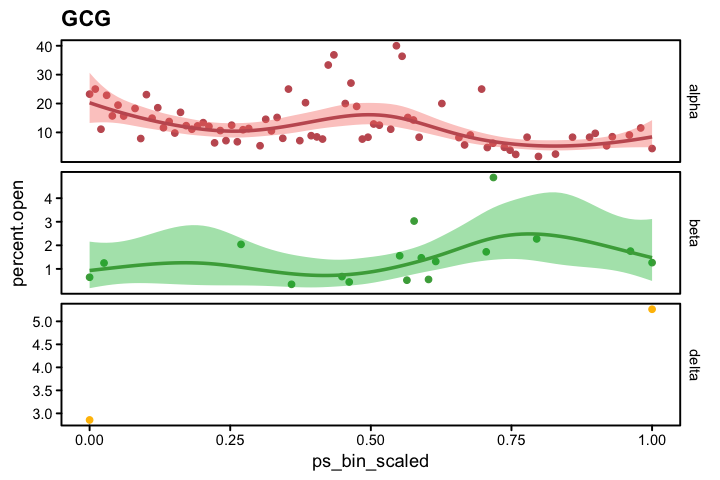

   user  system elapsed 
  0.424   0.054   0.477 

Joining, by = c("ps_bin", "celltype")


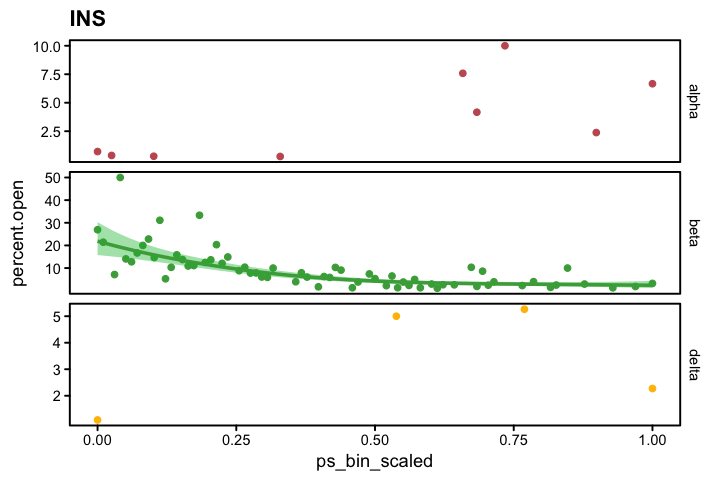

   user  system elapsed 
  0.436   0.020   0.454 

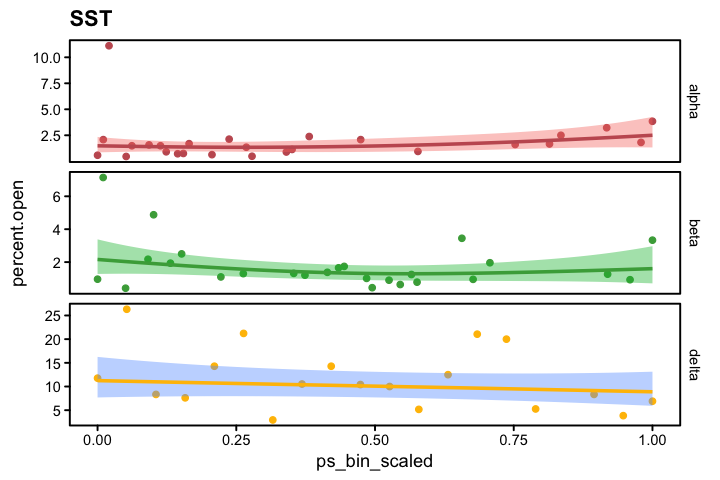

In [17]:
system.time(suppressWarnings(res <- fun.addSmoothFracPerBin(title = "GCG", doPlot = T, 
    npoints = 100, promoter = "2:163007699-163009094", sm_method = "gam", formula = y ~ 
    s(x, bs = "cs"))))
system.time(suppressWarnings(res <- fun.addSmoothFracPerBin(title = "INS", doPlot = T, 
    npoints = 100, promoter = "11:2182049-2182779", sm_method = "gam", formula = y ~ 
    s(x, bs = "cs"))))
system.time(suppressWarnings(res <- fun.addSmoothFracPerBin(title = "SST", doPlot = T, 
    npoints = 100, promoter = "3:187387788-187388467", sm_method = "gam", formula = y ~ 
    s(x, bs = "cs"))))

Joining, by = c("ps_bin", "celltype")


   user  system elapsed 
  0.423   0.021   0.444 

Joining, by = c("ps_bin", "celltype")


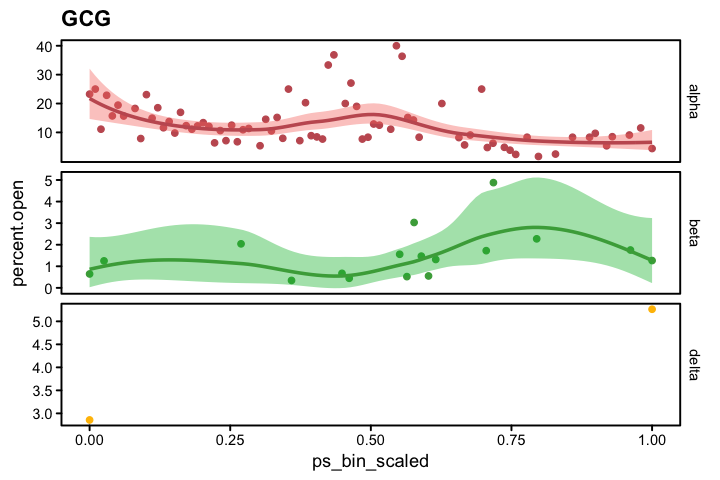

   user  system elapsed 
  0.427   0.006   0.432 

Joining, by = c("ps_bin", "celltype")


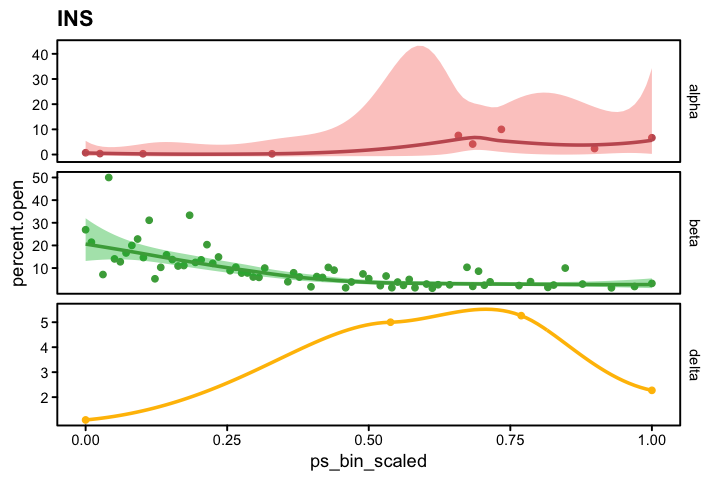

   user  system elapsed 
  0.439   0.022   0.461 

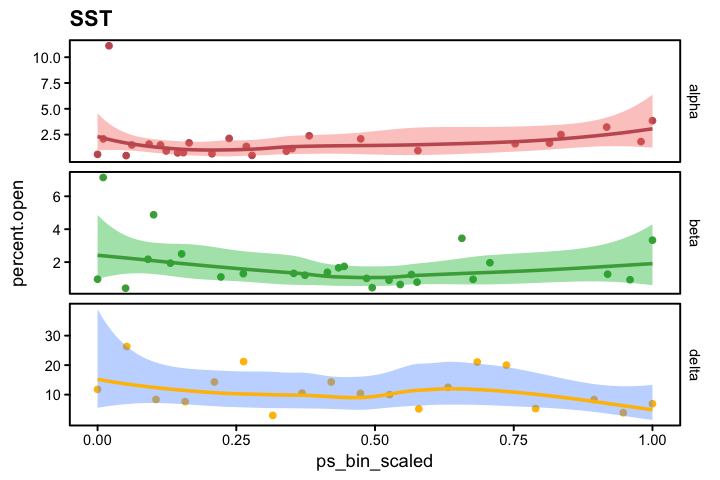

In [6]:
system.time(suppressWarnings(res <- fun.addSmoothFracPerBin(title = "GCG", doPlot = T, 
    npoints = 100, promoter = "2:163007699-163009094")))
system.time(suppressWarnings(res <- fun.addSmoothFracPerBin(title = "INS", doPlot = T, 
    npoints = 100, promoter = "11:2182049-2182779")))
system.time(suppressWarnings(res <- fun.addSmoothFracPerBin(title = "SST", doPlot = T, 
    npoints = 100, promoter = "3:187387788-187388467")))

## 3. prom<-> gene (connection)

### 3.1 heatmap

In [19]:
con.prom.gene <- fread("../figures/Fig2/subfigs/fig_2.prom.sub_vs_sub.fisher.csv") %>% 
    select(prom_peak, gene) %>% distinct

[1] 10


Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")


[1] 15


Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")


[1] 14


Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")
Joining, by = c("ps_bin", "celltype")


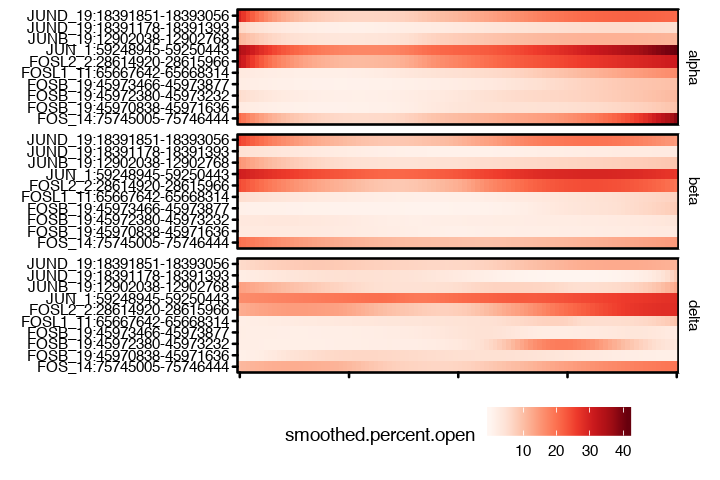

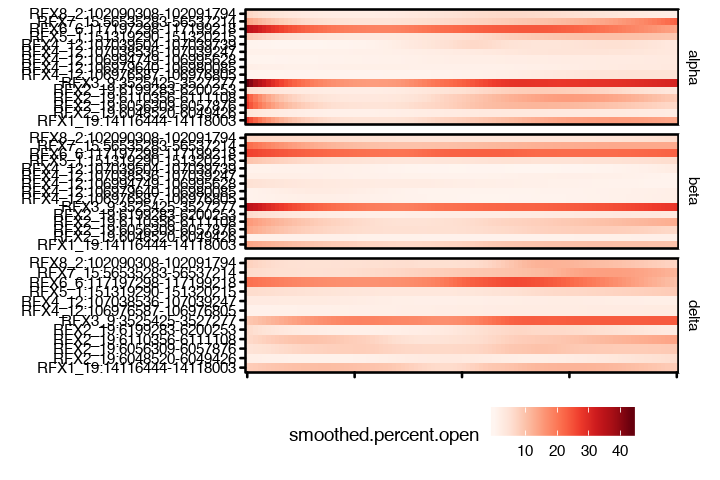

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

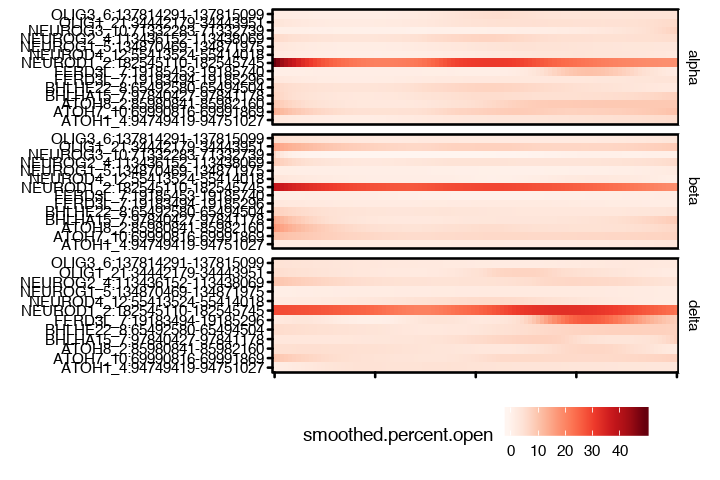

In [20]:
motif_gene_list <- list(`FOS::JUND` = c("FOSL1", "FOSL2", "FOS", "FOSB", "JUN", "JUND", 
    "JUNB"), Rfx1 = paste0("RFX", 1:8), NEUROD1 = c("ATOH1", "ATOH7", "ATOH8", "BHLHA15", 
    "BHLHE22", "BHLHE23", "FERD3L", "NEUROD1", "NEUROD2", "NEUROD4", "NEUROD6", "OLIG1", 
    "OLIG2", "OLIG3", "NEUROG1", "NEUROG2", "NEUROG3"))

suppressWarnings(lapply(1:3, function(i) {
    # select.genes <- c('FOSL1', 'FOSL2', 'FOS', 'FOSB', 'JUN', 'JUND', 'JUNB')
    select.genes <- motif_gene_list[[i]]
    target.proms.genes <- con.prom.gene %>% filter(gene %in% select.genes) %>% unite(prom, 
        2:1, sep = "_", remove = F)
    target.proms.genes %>% nrow %>% print
    tmp <- paste0(tempfile(), ".pdf")
    pdf(file = tmp, onefile = T)
    res <- do.call(rbind, lapply(1:nrow(target.proms.genes), function(i) {
        fun.addSmoothFracPerBin(npoints = 100, doPlot = T, title = target.proms.genes$prom[i], 
            promoter = target.proms.genes$prom_peak[i])$smoothed.data %>% mutate(gene_peak = target.proms.genes$prom[i])
    }))
    dev.off()
    system(paste("open", tmp))
    p <- ggplot(res, aes(ps, gene_peak, fill = smoothed.percent.open)) + geom_tile() + 
        facet_grid(scale = "free", celltype ~ .) + theme_pubr() + theme(legend.position = "bottom", 
        axis.title = element_blank(), axis.text.x = element_blank()) + coord_cartesian(expand = F, 
        clip = "off") + scale_fill_gradientn(colors = brewer.pal(n = 9, name = "Reds"))
    print(p)
    fn <- paste0("../figures/Fig2/subfigs/fig2f_motif_", names(motif_gene_list)[i], 
        "_prom_hm.pdf")
    ggsave(fn, p, width = 6, height = 4/10 * nrow(target.proms.genes), units = "in")
    system(paste0("open ", fn))
    fwrite(p$data, file = sub(".pdf", ".csv", fn), row.names = T)
    system(paste0("open ", sub(".pdf", ".csv", fn)))
    
}))
# colorRampPalette(brewer.pal(n = 9,name = 'Reds'))(100)

### 3.2 Spearman's correlation

In [44]:
spearman.cor <- do.call(rbind, lapply(c("FOS::JUND", "Rfx1", "NEUROD1"), function(m) {
    dat.motif <- fread(paste0("../figures/Fig2/subfigs/fig2f_motif_", m, "_ps_lines.csv"), 
        drop = 1)
    dat.prom <- fread(paste0("../figures/Fig2/subfigs/fig2f_motif_", m, "_prom_hm.csv"), 
        drop = 1)
    
    do.call(rbind, lapply(dat.motif %>% filter(motif == m) %>% pull(celltype) %>% 
        unique, function(ct) data.frame(cor.spearman = sapply(dat.prom %>% filter(celltype == 
        ct) %>% pull(gene_peak) %>% unique, function(g) cor(dat.prom %>% filter(celltype == 
        ct, gene_peak == g) %>% arrange(ps) %>% pull(smoothed.percent.open), dat.motif %>% 
        filter(motif == m, celltype == ct) %>% arrange(ps) %>% pull(zval), method = "spearman")), 
        celltype = ct, motif = m) %>% rownames_to_column("gene_peak")))
}))
fwrite(spearman.cor, "../figures/Fig2/subfigs/fig2f_motif_prom_speaman.cor.csv")
system("open ../figures/Fig2/subfigs/fig2f_motif_prom_speaman.cor.csv")

In [45]:
spearman.cor %>% group_by(celltype, motif) %>% top_n(1, cor.spearman)
fwrite(spearman.cor %>% group_by(celltype, motif) %>% top_n(1, cor.spearman), "../figures/Fig2/subfigs/fig2f_motif_prom.max.speaman_cor.csv")
system("open ../figures/Fig2/subfigs/fig2f_motif_prom.max.speaman_cor.csv")

gene_peak,cor.spearman,celltype,motif
FOSL1_11:65667642-65668314,0.8106451,alpha,FOS::JUND
FOSL2_2:28614920-28615966,0.7115872,beta,FOS::JUND
JUN_1:59248945-59250443,0.7716172,delta,FOS::JUND
RFX6_6:117197298-117199218,0.3942514,alpha,Rfx1
RFX4_12:106994749-106995628,0.8242904,beta,Rfx1
RFX4_12:107038536-107039247,0.3077108,delta,Rfx1
NEUROD1_2:182545110-182545745,0.6168017,alpha,NEUROD1
NEUROD1_2:182545110-182545745,0.8518092,beta,NEUROD1
ATOH1_4:94749419-94751027,0.7534833,delta,NEUROD1


## 4. Refine to one gene one tss

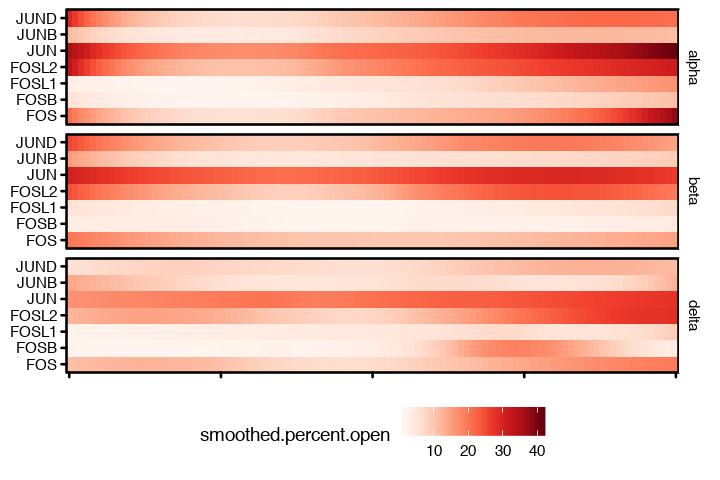

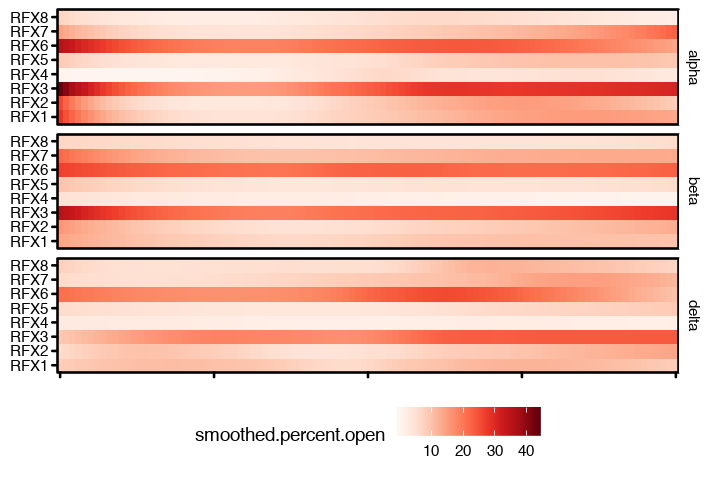

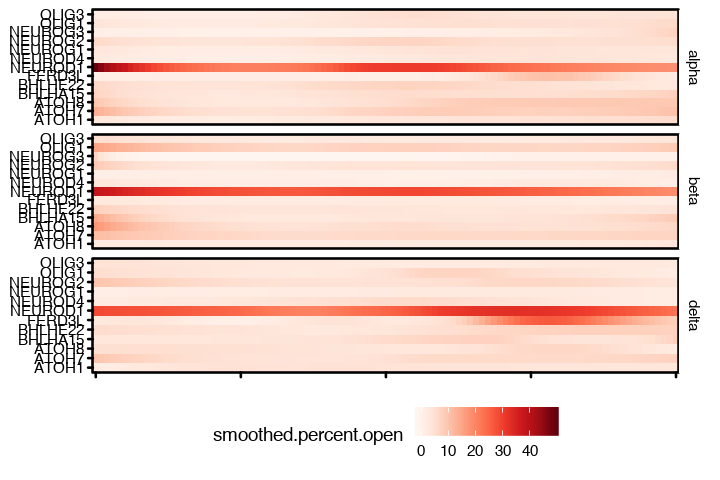

In [73]:
for (m in c("FOS::JUND", "Rfx1", "NEUROD1")) {
    dat.prom <- fread(paste0("../figures/Fig2/subfigs/fig2f_motif_", m, "_prom_hm.csv"), 
        drop = 1) %>% separate(gene_peak, c("gene", "peak"), sep = "_", remove = F)
    
    dat.prom.s <- dat.prom %>% group_by(celltype, gene, peak, gene_peak) %>% summarise(avg.open = mean(smoothed.percent.open))
    dat.prom.s <- dat.prom.s %>% right_join(dat.prom.s %>% ungroup() %>% group_by(celltype, 
        gene) %>% summarise(avg.open = max(avg.open)))
    dat.prom <- dat.prom %>% right_join(dat.prom.s) %>% select(-gene_peak)
    p <- ggplot(dat.prom, aes(ps, gene, fill = smoothed.percent.open)) + geom_tile() + 
        facet_grid(scale = "free", celltype ~ .) + theme_pubr() + theme(legend.position = "bottom", 
        axis.title = element_blank(), axis.text.x = element_blank()) + coord_cartesian(expand = F, 
        clip = "off") + scale_fill_gradientn(colors = brewer.pal(n = 9, name = "Reds"))
    print(p)
    fn <- paste0("../figures/Fig2/subfigs/fig2f_motif_", m, "_prom_hm.pdf")
    ggsave(fn, p, width = 6, height = ifelse(m == "NEUROD1", 5, 4), units = "in")
    system(paste0("open ", fn))
    fwrite(p$data, file = sub(".pdf", ".csv", fn), row.names = T)
    system(paste0("open ", sub(".pdf", ".csv", fn)))
}

In [52]:
dat.prom <- (dat.prom %>% separate(gene_peak,group_by(celltype, gene_peak) %>% summarise(avg.open.max = max(mean(smoothed.percent.open))) %>% 
    select(-avg.open.max)) %>% left_join(dat.prom)
dat.prom %>% head(1)

Joining, by = c("celltype", "gene_peak")


celltype,gene_peak,ps,smoothed.percent.open
alpha,FOS_14:75745005-75746444,0,20.82831


In [74]:
spearman.cor <- do.call(rbind, lapply(c("FOS::JUND", "Rfx1", "NEUROD1"), function(m) {
    dat.motif <- fread(paste0("../figures/Fig2/subfigs/fig2f_motif_", m, "_ps_lines.csv"), 
        drop = 1)
    dat.prom <- fread(paste0("../figures/Fig2/subfigs/fig2f_motif_", m, "_prom_hm.csv"), 
        drop = 1)
    
    do.call(rbind, lapply(dat.motif %>% filter(motif == m) %>% pull(celltype) %>% 
        unique, function(ct) data.frame(cor.spearman = sapply(dat.prom %>% filter(celltype == 
        ct) %>% pull(gene) %>% unique, function(g) cor(dat.prom %>% filter(celltype == 
        ct, gene == g) %>% arrange(ps) %>% pull(smoothed.percent.open), dat.motif %>% 
        filter(motif == m, celltype == ct) %>% arrange(ps) %>% pull(zval), method = "spearman")), 
        celltype = ct, motif = m) %>% rownames_to_column("gene")))
}))
fwrite(spearman.cor, "../figures/Fig2/subfigs/fig2f_motif_prom_speaman.cor.csv")
system("open ../figures/Fig2/subfigs/fig2f_motif_prom_speaman.cor.csv")

spearman.cor %>% group_by(celltype, motif) %>% top_n(1, cor.spearman)
fwrite(spearman.cor %>% group_by(celltype, motif) %>% top_n(1, cor.spearman), "../figures/Fig2/subfigs/fig2f_motif_prom.max.speaman_cor.csv")
system("open ../figures/Fig2/subfigs/fig2f_motif_prom.max.speaman_cor.csv")

gene,cor.spearman,celltype,motif
FOSL1,0.8106451,alpha,FOS::JUND
FOSL2,0.7115872,beta,FOS::JUND
JUN,0.7716172,delta,FOS::JUND
RFX6,0.3942514,alpha,Rfx1
RFX4,0.8242904,beta,Rfx1
RFX4,0.3077108,delta,Rfx1
NEUROD1,0.6168017,alpha,NEUROD1
NEUROD1,0.8518092,beta,NEUROD1
ATOH1,0.7534833,delta,NEUROD1
